# **Stress Facial Expression Classification Project**

### **IMPORTS & SETUP**

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report

from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

### **PATHS & CONFIGURATION**

In [ ]:
base_dir = "images"  # FER2013 dataset base folder
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# New merged dataset output path
output_base = "stress_dataset"
os.makedirs(output_base, exist_ok=True)
for split in ['train', 'test']:
    for category in ['stressed', 'not_stressed']:
        os.makedirs(os.path.join(output_base, split, category), exist_ok=True)

### **STEP 2️⃣: EMOTION MAPPING & DATA MERGE**

In [ ]:
stressed = ['angry', 'disgust', 'fear', 'sad', 'neutral']
not_stressed = ['happy', 'surprise']

def move_images(source_split, target_label, class_list):
    for emotion in class_list:
        src_folder = os.path.join(base_dir, source_split, emotion)
        dest_folder = os.path.join(output_base, source_split, target_label)
        if not os.path.exists(src_folder):
            print(f" Skipped missing folder: {src_folder}")
            continue
        for img_file in os.listdir(src_folder):
            src = os.path.join(src_folder, img_file)
            dst = os.path.join(dest_folder, img_file)
            try:
                shutil.copy(src, dst)
            except Exception as e:
                pass

move_images("train", "stressed", stressed)
move_images("train", "not_stressed", not_stressed)
move_images("test", "stressed", stressed)
move_images("test", "not_stressed", not_stressed)

print(" Stress dataset created successfully at:", output_base)


### **DATA GENERATORS**

In [3]:
img_size = 96 
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    os.path.join(output_base, "train"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    os.path.join(output_base, "train"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(output_base, "test"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 22930 images belonging to 2 classes.
Found 5732 images belonging to 2 classes.
Found 7171 images belonging to 2 classes.


### **BUILD MODEL — MobileNetV2**

#### **MODEL ARCHITECTURE**

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3), alpha=1.0)

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

### **FINE-TUNING**

In [ ]:
# Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

### **CALLBACKS**

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('fine_tuned_stress_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
]

### **STEP 🔟: TRAIN MODEL**

In [12]:
steps_per_epoch = train_gen.samples // batch_size
validation_steps = val_gen.samples // batch_size

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/50
716/716 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.6886
Epoch 1: val_loss improved from inf to 0.77575, saving model to fine_tuned_stress_model.h5
716/716 [==============================] - 45s 57ms/step - loss: 0.7078 - accuracy: 0.6886 - val_loss: 0.7758 - val_accuracy: 0.7334 - lr: 1.0000e-04
Epoch 2/50
716/716 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.7891
Epoch 2: val_loss improved from 0.77575 to 0.73086, saving model to fine_tuned_stress_model.h5
716/716 [==============================] - 40s 56ms/step - loss: 0.5034 - accuracy: 0.7891 - val_loss: 0.7309 - val_accuracy: 0.7032 - lr: 1.0000e-04
Epoch 3/50
716/716 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.8180
Epoch 3: val_loss did not improve from 0.73086
716/716 [==============================] - 39s 55ms/step - loss: 0.4301 - accuracy: 0.8180 - val_loss: 0.8702 - val_accuracy: 0.6678 - lr: 1.0000e-04
Epoch 4/50
715/716 [=========

### **STEP 11️⃣: EVALUATE ON TEST DATA**

In [13]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f" Test Accuracy: {test_acc * 100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

225/225 [==============================] - 3s 13ms/step - loss: 0.2779 - accuracy: 0.8903
 Test Accuracy: 89.03%
 Test Loss: 0.2779


### **TRAINING GRAPHS**

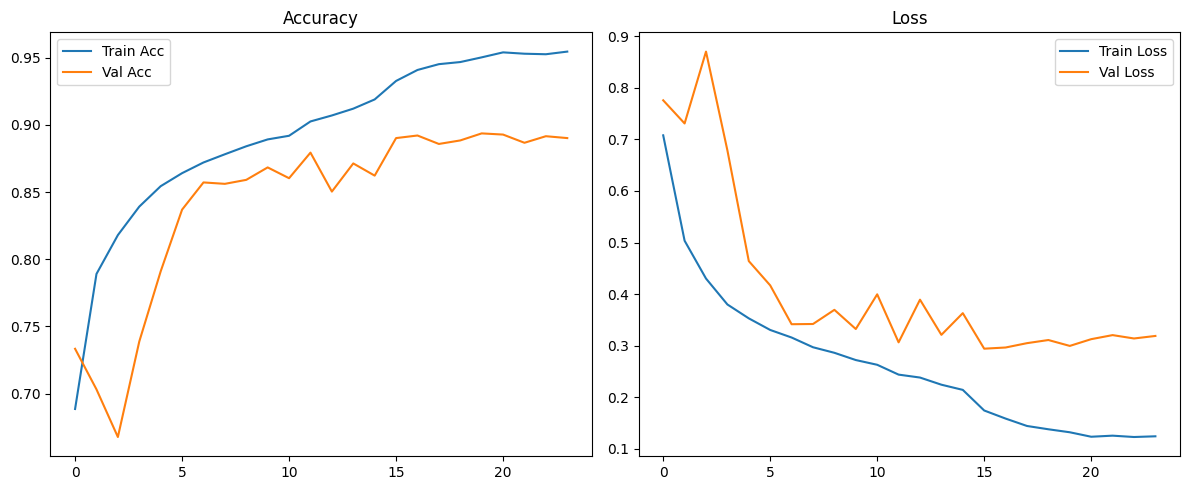

In [14]:
# Accuracy Graph
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history.history['accuracy'], label='Train Acc')
axes[0].plot(history.history['val_accuracy'], label='Val Acc')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Loss')
axes[1].legend()
plt.tight_layout()
plt.show()

### **SAVE MODEL**

In [15]:
model.save("mobilenetv2_stress_detection.h5")
print("Model saved as mobilenetv2_stress_detection.h5")

Model saved as mobilenetv2_stress_detection.h5


### **CONFUSION MATRIX + CLASSIFICATION REPORT**

In [16]:
best_model = load_model("mobilenetv2_stress_detection.h5")

#### **Model load evaluate on test set**

In [17]:
test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

225/225 [==============================] - 3s 11ms/step - loss: 0.2779 - accuracy: 0.8903
Test Accuracy: 0.8903, Test Loss: 0.2779


### **Predictions**

In [18]:
y_pred = best_model.predict(test_gen, verbose=1)
y_pred_classes = (y_pred > 0.5).astype(int).ravel()
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

225/225 [==============================] - 3s 11ms/step


### **Confusion Matrix**

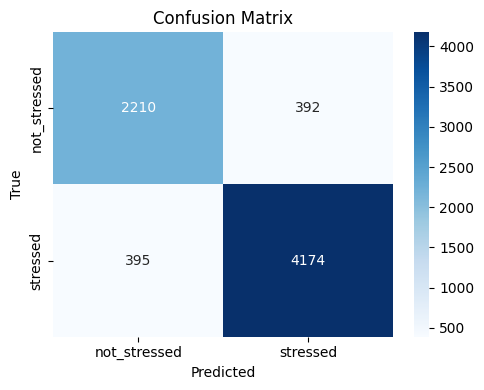

In [19]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


### **Classification Report**

In [20]:
report = classification_report(y_true, y_pred_classes, target_names=class_labels, digits=2)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

not_stressed       0.85      0.85      0.85      2602
    stressed       0.91      0.91      0.91      4569

    accuracy                           0.89      7171
   macro avg       0.88      0.88      0.88      7171
weighted avg       0.89      0.89      0.89      7171



### **Accuracy/Loss Graphs**

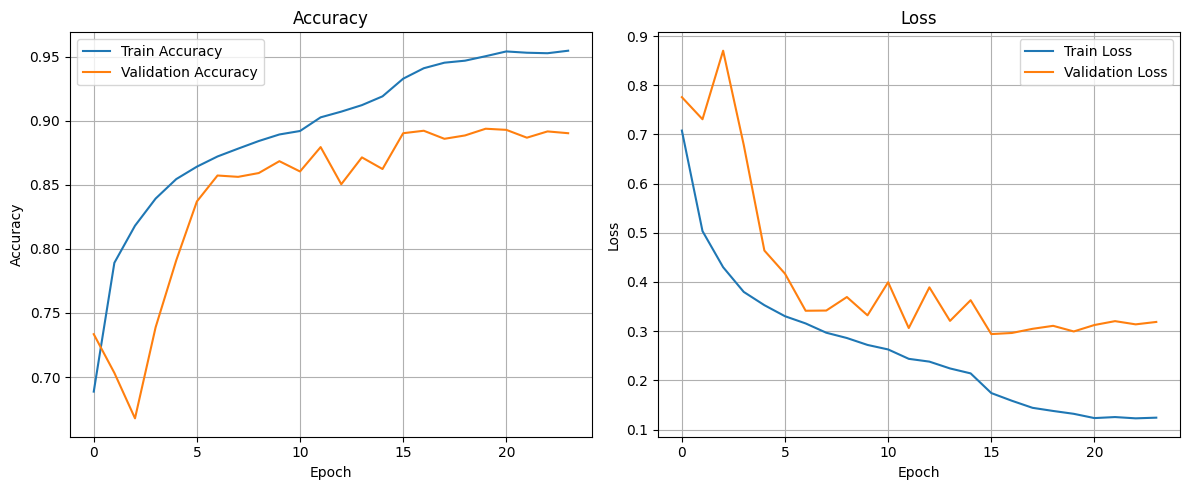

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Graph
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss Graph
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)
plt.show()

## **Generate PDF Report**

In [22]:
# Extract last epoch metrics from history
final_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

report_name = "Stress_Detection_Model_Report_4.pdf"
doc = SimpleDocTemplate(report_name, pagesize=letter)
styles = getSampleStyleSheet()
story = []

# ------------------- HEADER -------------------
story.append(Paragraph("<b>Facial Expression Stress Detection Report</b>", styles['Title']))
story.append(Spacer(1, 8))
story.append(Paragraph(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", styles['Normal']))
story.append(Spacer(1, 12))

# ------------------- MODEL INFO -------------------
story.append(Paragraph("<b>Model Information:</b>", styles['Heading2']))
story.append(Paragraph("Architecture: MobileNetV2 (Transfer Learning + Fine-tuning)", styles['Normal']))
story.append(Paragraph("Input Size: 96x96x3", styles['Normal']))
story.append(Paragraph("Output Classes: 2 (Not Stressed, Stressed)", styles['Normal']))
story.append(Spacer(1, 10))

# ------------------- PERFORMANCE METRICS -------------------
story.append(Paragraph("<b>Final Epoch Metrics:</b>", styles['Heading2']))
story.append(Paragraph(f"Final Training Accuracy: {final_acc:.4f}", styles['Normal']))
story.append(Paragraph(f"Final Validation Accuracy: {final_val_acc:.4f}", styles['Normal']))
story.append(Paragraph(f"Final Training Loss: {final_loss:.4f}", styles['Normal']))
story.append(Paragraph(f"Final Validation Loss: {final_val_loss:.4f}", styles['Normal']))
story.append(Spacer(1, 10))

story.append(Paragraph("<b>Test Performance:</b>", styles['Heading2']))
story.append(Paragraph(f"Test Accuracy: {test_acc:.4f}", styles['Normal']))
story.append(Paragraph(f"Test Loss: {test_loss:.4f}", styles['Normal']))
story.append(Spacer(1, 12))

# ------------------- VISUAL LAYOUT -------------------
# Arrange Accuracy, Loss, and Confusion Matrix side by side
# Instead of separate files:
training_img = RLImage("training_curves.png", width=360, height=180)
confusion_img = RLImage("confusion_matrix.png", width=200, height=160)

table_data = [
    [training_img, confusion_img]
]

table = Table(table_data, colWidths=[360, 200])
table.setStyle(TableStyle([
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.gray),
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.lightgrey)
]))
story.append(table)
story.append(Spacer(1, 16))

# ------------------- CLASSIFICATION REPORT -------------------
story.append(Paragraph("<b>Classification Report:</b>", styles['Heading2']))
story.append(Paragraph(f"<pre>{report}</pre>", styles['Code']))
story.append(Spacer(1, 12))

doc.build(story)
print(f" PDF report saved successfully as: {report_name}")

 PDF report saved successfully as: Stress_Detection_Model_Report_4.pdf


# **Predictions Application**

#### **Single Image Testing**

In [23]:
import os
import cv2
import numpy as np
from keras.models import load_model

# Load trained model
model = load_model("mobilenetv2_stress_detection.h5")

# Labels
labels = ["Not Stressed", "Stressed"]

# Path of image or folder
image_dir = "PrivateTest_134207.jpg"  # can be folder OR single image path

def predict_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f" Could not read: {img_path}")
        return

    img_resized = cv2.resize(img, (96, 96))
    img_normalized = img_resized.astype("float32") / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)

    # Prediction (sigmoid output → value between 0 and 1)
    pred = model.predict(img_input)[0][0]

    # Threshold logic (sigmoid output)
    label = labels[1] if pred >= 0.5 else labels[0]
    print(f"{os.path.basename(img_path)} → {label} ({pred:.4f})")

# If single image
if os.path.isfile(image_dir):
    predict_image(image_dir)
# If folder
else:
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        predict_image(img_path)

1/1 [==============================] - 1s 838ms/step
PrivateTest_134207.jpg → Stressed (0.9612)


### **Predictions**

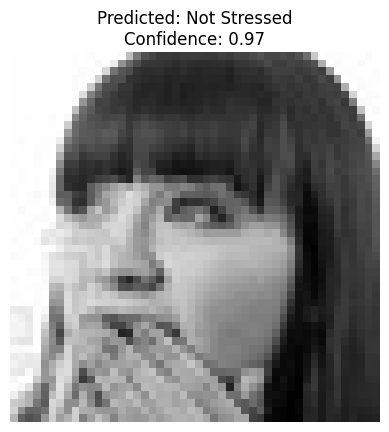

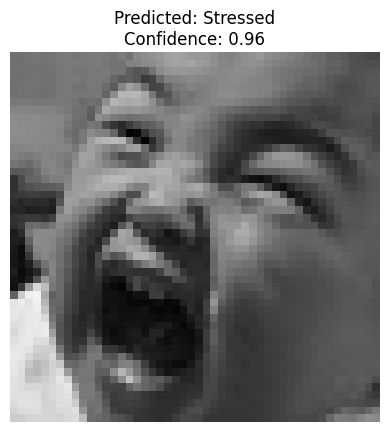

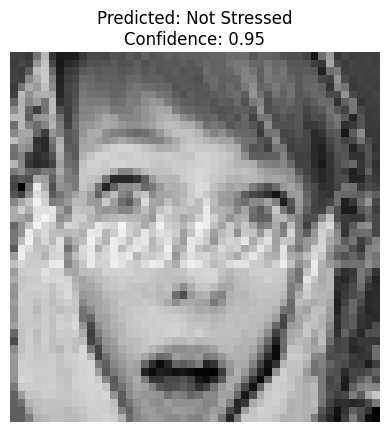

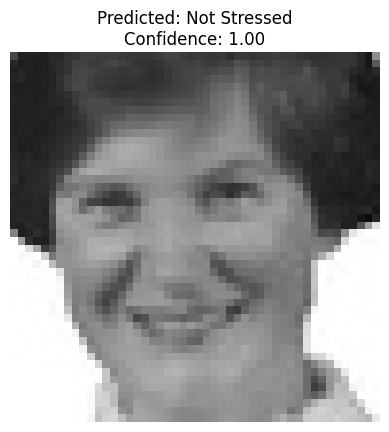

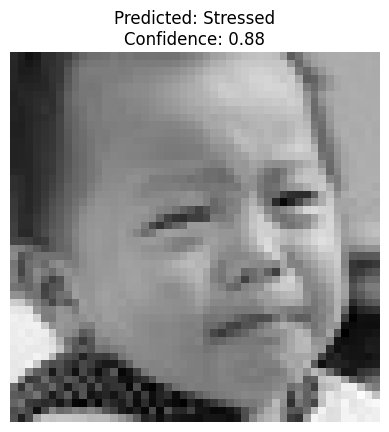

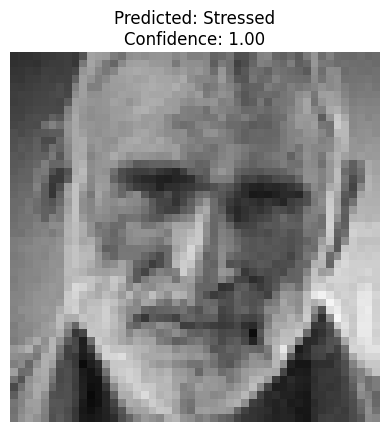

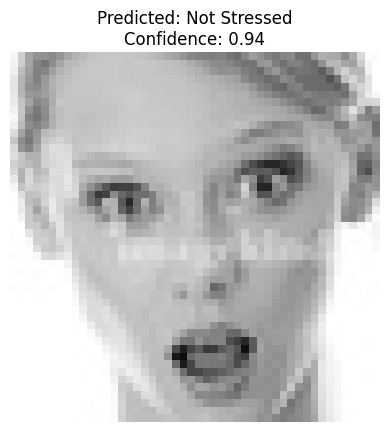

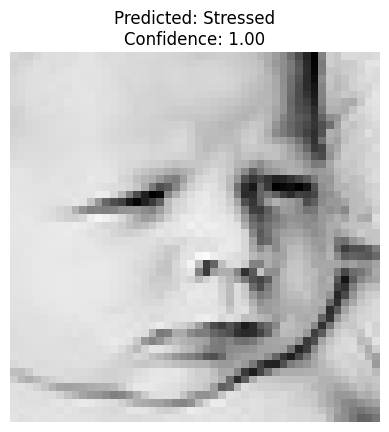

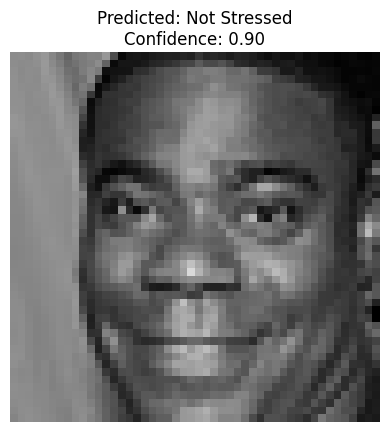

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load trained model
model = load_model("mobilenetv2_stress_detection.h5")

# Labels
labels = ["Not Stressed", "Stressed"]

# Constants
IMG_SIZE = 96
TEST_DIR = "test"  # All mixed images inside this folder

# Predict function
def predict_image(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized.astype("float32") / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)

    # Model prediction
    pred = model.predict(img_input, verbose=0)[0][0]
    label = labels[1] if pred >= 0.5 else labels[0]
    confidence = pred if pred >= 0.5 else 1 - pred
    return label, confidence, img_rgb

# Loop through test folder
for img_name in os.listdir(TEST_DIR):
    img_path = os.path.join(TEST_DIR, img_name)
    if not (img_path.endswith(".jpg") or img_path.endswith(".png") or img_path.endswith(".jpeg")):
        continue

    label, conf, img_rgb = predict_image(img_path)

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Predicted: {label}\nConfidence: {conf:.2f}")
    plt.show()